In [1]:
import osmnx as ox
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from shapely.geometry import Point
from geopy.distance import geodesic
import math
from networkx.algorithms.simple_paths import shortest_simple_paths

In [2]:
# --- Parámetros globales ---
PLACE = "Salamanca, Madrid, Spain"
CSV_PATH = "../data/graph_data/TL_coords.csv"
GRAPH_PATH = "../data/graph_data/graph_weighted_full.graphml"
THRESHOLD_METERS = 5

# Penalizaciones
SEMAFORO_PENALTY = 15
INTERSECTION_3_PENALTY = 2
INTERSECTION_4_PENALTY = 4
LEFT_TURN_PENALTY = 4
RIGHT_TURN_PENALTY = 8
SPEED_M_PER_S = 5  # supuesta velocidad media

##### Descargar Grafo

In [3]:
G = ox.graph_from_place(PLACE, network_type="drive")

# ———————— Enforce OSM “oneway” ————————
# Para cada arista en el grafo de OSMnx,
# si tiene oneway=yes (o True/“1”), borramos la arista inversa.
for u, v, key, data in list(G.edges(keys=True, data=True)):
    oneway = data.get("oneway", False)
    # OSMnx puede representarlo como True, 'yes', '1'
    if str(oneway).lower() in ("true", "yes", "1"):
        # si existe la inversa, la borramos
        if G.has_edge(v, u, key):
            G.remove_edge(v, u, key)
    # además, OSM usa oneway='-1' para indicar que solo 
    # se puede ir de v→u, así quítale la dirección directa:
    elif str(oneway) == "-1":
        if G.has_edge(u, v, key):
            G.remove_edge(u, v, key)


##### Clasificación nodos

In [4]:
df_semaforos = pd.read_csv(CSV_PATH)
semaforo_coords = list(zip(df_semaforos["GPSLatitude"], df_semaforos["GPSLongitude"]))

for node, data in G.nodes(data=True):
    coord_node = (data["y"], data["x"])
    # ¿Está cerca de un semáforo real?
    if any(geodesic(coord_node, coord).meters < THRESHOLD_METERS for coord in semaforo_coords):
        data["type"] = "semaforo"
    else:
        sc = data.get("street_count", 0)
        if sc == 2:
            data["type"] = "interseccion_2"
        elif sc == 3:
            data["type"] = "interseccion_3"
        elif sc >= 4:
            data["type"] = "interseccion_4+"
        else:
            data["type"] = "irrelevante"


##### Visualización Grafo

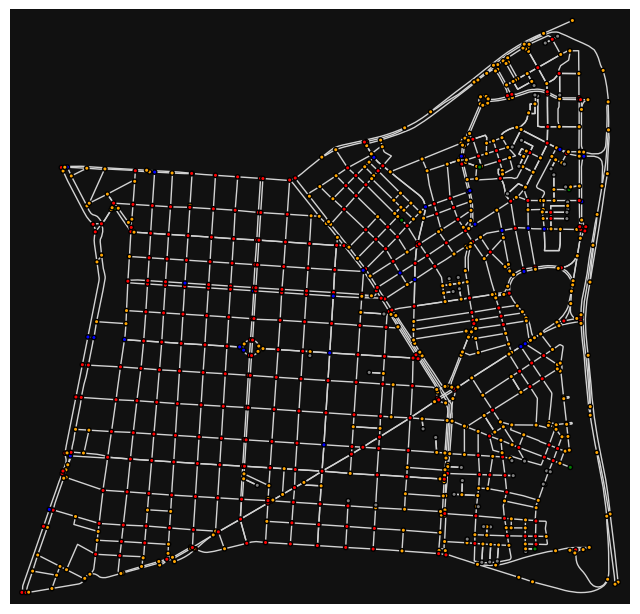

In [5]:
color_map = {
    "semaforo": "blue",
    "interseccion_2": "green",
    "interseccion_3": "orange",
    "interseccion_4+": "red",
    "irrelevante": "gray"
}

pos = {node: (data['x'], data['y']) for node, data in G.nodes(data=True)}
node_colors = [color_map.get(data.get("type", "irrelevante"), "gray") for _, data in G.nodes(data=True)]
node_sizes = [10] * len(G.nodes)

fig, ax = ox.plot_graph(G, node_size=0, edge_color='lightgray', show=False, close=False)
ax.scatter([pos[n][0] for n in G.nodes], [pos[n][1] for n in G.nodes], c=node_colors, s=node_sizes, edgecolors='black')
plt.show()

##### Asignación de pesos

In [6]:
def calculate_turn_angle(u, v, w):
    try:
        x1, y1 = G.nodes[u]['x'], G.nodes[u]['y']
        x2, y2 = G.nodes[v]['x'], G.nodes[v]['y']
        x3, y3 = G.nodes[w]['x'], G.nodes[w]['y']
        vec1 = (x2 - x1, y2 - y1)
        vec2 = (x3 - x2, y3 - y2)
        dot = vec1[0]*vec2[0] + vec1[1]*vec2[1]
        mag1 = math.hypot(*vec1)
        mag2 = math.hypot(*vec2)
        if mag1 * mag2 == 0:
            return 0
        cos_angle = dot / (mag1 * mag2)
        angle_rad = math.acos(min(1, max(-1, cos_angle)))
        return math.degrees(angle_rad)
    except:
        return 0
    
def clean_graph_for_graphml(G):
    import shapely.geometry
    allowed_types = (int, float, str, bool)

    # Limpiar nodos
    for _, data in G.nodes(data=True):
        for key in list(data):
            if not isinstance(data[key], allowed_types):
                del data[key]

    # Limpiar aristas
    for _, _, data in G.edges(data=True):
        for key in list(data):
            if not isinstance(data[key], allowed_types):
                del data[key]



for u, v, data in G.edges(data=True):
    length = float(data.get('length', 1))
    weight = length / SPEED_M_PER_S

    for node in [u, v]:
        tipo = G.nodes[node].get('type', '')
        if tipo == 'semaforo':
            weight += SEMAFORO_PENALTY
        elif tipo == 'interseccion_3':
            weight += INTERSECTION_3_PENALTY
        elif tipo == 'interseccion_4+':
            weight += INTERSECTION_4_PENALTY

    successors = list(G.successors(v)) if hasattr(G, 'successors') else []
    if successors:
        next_node = successors[0]
        angle = calculate_turn_angle(u, v, next_node)
        if angle > 180:
            angle = 360 - angle
        if angle > 100:
            weight += LEFT_TURN_PENALTY
        elif angle < 80:
            weight += RIGHT_TURN_PENALTY

    data['weight'] = weight

clean_graph_for_graphml(G)
nx.write_graphml(G, GRAPH_PATH)

##### Métricas de ruta

In [7]:
def route_metrics(G, path):
    total_length = 0
    sem = senal = int3 = int4 = left = right = 0
    for u, v in zip(path[:-1], path[1:]):
        edge = G[u][v][0]
        total_length += float(edge.get("length", 0))
        t = G.nodes[u]["type"]
        if t == "semaforo": sem += 1
        elif t == "senal": senal += 1
        elif t == "interseccion_3": int3 += 1
        elif t == "interseccion_4+": int4 += 1
    last_t = G.nodes[path[-1]]["type"]
    if last_t == "semaforo": sem += 1
    for u, v, w in zip(path[:-2], path[1:-1], path[2:]):
        ang = calculate_turn_angle(u, v, w)
        if ang > 180: ang = 360 - ang
        if ang > 100: left += 1
        elif ang < 80: right += 1
    travel_time = total_length / SPEED_M_PER_S
    weighted_cost = sum(float(G[e1][e2][0]['weight']) for e1, e2 in zip(path[:-1], path[1:]))
    return {
        'coste_ponderado': weighted_cost,
        'distancia_m': total_length,
        'tiempo_s': travel_time,
        'nodos': len(path),
        'interseccion_3': int3,
        'interseccion_4+': int4,
    }

In [10]:
# --- Fase 5: Cálculo de rutas ---
orig=(40.442163,-3.663568); dest=(40.424965,-3.678606)
start=min(G.nodes, key=lambda n: geodesic(orig,(G.nodes[n]['y'],G.nodes[n]['x'])).meters)
end=min(G.nodes,   key=lambda n: geodesic(dest,(G.nodes[n]['y'],G.nodes[n]['x'])).meters)
# Dijkstra penalizado
ruta_dij=nx.shortest_path(G,start,end,weight='weight'); metr_dij=route_metrics(G,ruta_dij)
# A*
ruta_astar=nx.astar_path(G,start,end,weight='weight'); metr_astar=route_metrics(G,ruta_astar)
# Solo distancia
ruta_dist=nx.shortest_path(G,start,end,weight='length'); metr_dist=route_metrics(G,ruta_dist)
# Dijkstra solo distancia (sin penalizaciones)
G_nopen=G.copy()
for u,v,data in G_nopen.edges(data=True): data['weight']=float(data.get('length',1))/SPEED_M_PER_S
ruta_nopen=nx.shortest_path(G_nopen,start,end,weight='weight'); metr_nopen=route_metrics(G_nopen,ruta_nopen)


C:\Users\Gabriel\AppData\Local\Temp\ipykernel_17172\2045999215.py:6: UserWarning: 

The connectionstyle keyword argument is not applicable when drawing edges
with LineCollection.

To make this warning go away, either specify `arrows=True` to
force FancyArrowPatches or use the default value for connectionstyle.
Note that using FancyArrowPatches may be slow for large graphs.

  lc_dij = nx.draw_networkx_edges(
C:\Users\Gabriel\AppData\Local\Temp\ipykernel_17172\2045999215.py:50: UserWarning: 

The connectionstyle keyword argument is not applicable when drawing edges
with LineCollection.

To make this warning go away, either specify `arrows=True` to
force FancyArrowPatches or use the default value for connectionstyle.
Note that using FancyArrowPatches may be slow for large graphs.

  lc_nopen = nx.draw_networkx_edges(
C:\Users\Gabriel\AppData\Local\Temp\ipykernel_17172\2045999215.py:67: UserWarning: 

The connectionstyle keyword argument is not applicable when drawing edges
with LineColle

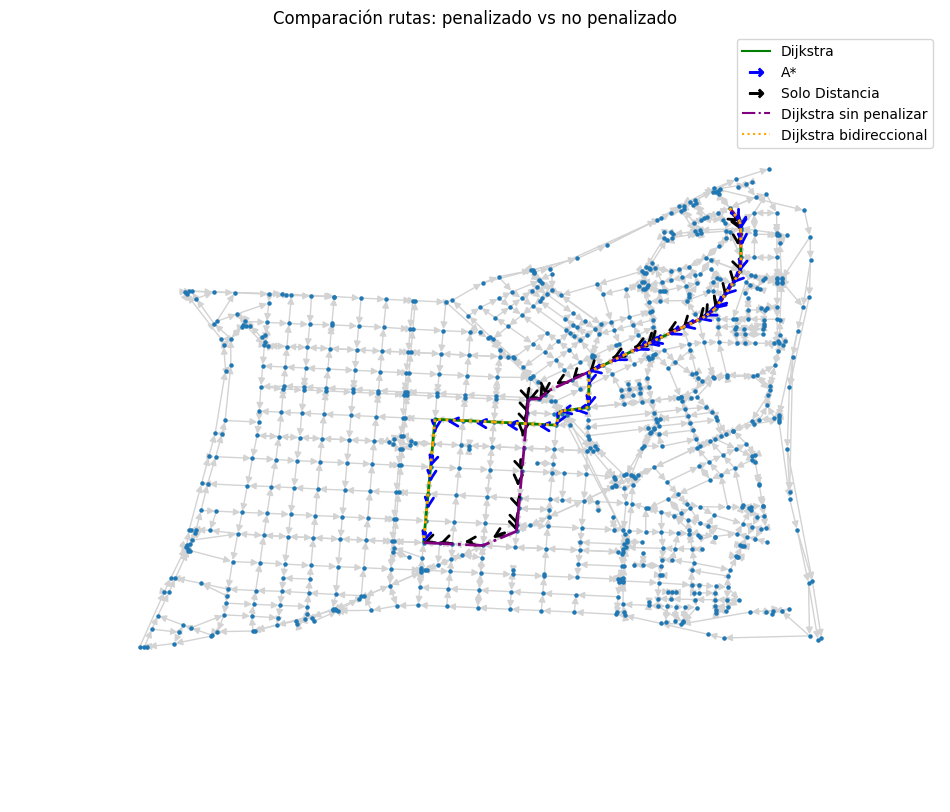

,Algoritmo,coste_ponderado,distancia_m,tiempo_s,nodos,interseccion_3,interseccion_4+
0,Dijkstra penalizado,991.882255,2879.411277,575.882255,33,8,22
1,A*,991.882255,2879.411277,575.882255,33,8,22
2,Solo Distancia,1008.857545,2744.287723,548.857545,37,13,21
3,Dijkstra sin penalizar,548.857545,2744.287723,548.857545,37,13,21
4,Bidireccional,991.882255,2879.411277,575.882255,33,8,22


Ruta Dijkstra penalizado: [150338722, 149218224, 149217964, 149217960, 150341881, 149218222, 149228346, 149229866, 327601929, 143618241, 27512901, 149217257, 3470094576, 149205756, 149207565, 149191474, 149207875, 143659990, 60015592, 60015591, 1537861047, 27509101, 27509100, 28096859, 28096858, 28096857, 29741516, 28096615, 29480652, 28096619, 28097224, 28096710, 25552414]
Ruta A*: [150338722, 149218224, 149217964, 149217960, 150341881, 149218222, 149228346, 149229866, 327601929, 143618241, 27512901, 149217257, 3470094576, 149205756, 149207565, 149191474, 149207875, 143659990, 60015592, 60015591, 1537861047, 27509101, 27509100, 28096859, 28096858, 28096857, 29741516, 28096615, 29480652, 28096619, 28097224, 28096710, 25552414]
Ruta Solo Distancia: [150338722, 149218224, 149217964, 149217960, 150341881, 149218222, 149228346, 149229866, 327601929, 143618241, 27512901, 149217257, 3470094576, 149205756, 149207565, 149191474, 149207875, 143659990, 60015592, 143656434, 27509103, 27509098, 36

In [20]:
# --- Fase 6: Visualización comparativa ---
pos={n:(G.nodes[n]['x'],G.nodes[n]['y']) for n in G.nodes}
fig,ax=plt.subplots(figsize=(12,10))
nx.draw(G,pos,node_size=5,edge_color='lightgray',with_labels=False,ax=ax)
# Dijkstra curva
lc_dij = nx.draw_networkx_edges(
    G, pos,
    edgelist=list(zip(ruta_dij[:-1], ruta_dij[1:])),
    edge_color='green',
    width=2,               # línea más fina
    style='-',
    arrows=False,
    connectionstyle='arc3,rad=0.1',
    ax=ax
)
lc_dij.set_zorder(2)
# A*
lc_astar = nx.draw_networkx_edges(
    G, pos,
    edgelist=list(zip(ruta_astar[:-1], ruta_astar[1:])),
    edge_color='blue',
    width=2,
    style='--',
    arrows=True,
    arrowstyle='->',
    arrowsize=15,
    connectionstyle='arc3,rad=-0.1',
    ax=ax
)
for art in lc_astar: 
    art.set_zorder(5)

# Solo distancia curva negra
lc_dist=nx.draw_networkx_edges(
    G,pos,
    edgelist=list(zip(ruta_dist[:-1],ruta_dist[1:])),
    edge_color='black',
    width=2,
    style='-',
    arrows=True,
    arrowstyle='->',
    arrowsize=15,
    connectionstyle='arc3,rad=0.2',
    ax=ax); 

for art in lc_dist:
    art.set_zorder(3)

# Dijkstra sin penalizar curva morada
lc_nopen = nx.draw_networkx_edges(
    G, pos,
    edgelist=list(zip(ruta_nopen[:-1], ruta_nopen[1:])),
    edge_color='purple',
    width=2,
    style='-.',
    arrows=False,
    connectionstyle='arc3,rad=-0.2',
    ax=ax
)
lc_nopen.set_zorder(4)

# Dijkstra bidireccional
length_bidi, ruta_bidi = nx.bidirectional_dijkstra(G, start, end, weight='weight')
metr_bidi = route_metrics(G, ruta_bidi)

# Dijkstra bidireccional
lc_dij_bidi = nx.draw_networkx_edges(
    G, pos,
    edgelist=list(zip(ruta_bidi[:-1], ruta_bidi[1:])),
    edge_color='orange',
    width=2,
    style=':',
    arrows=False,
    connectionstyle='arc3,rad=0.3',
    ax=ax
)
lc_dij_bidi.set_zorder(7)

# Dijkstra bidireccional
length_bidi, ruta_bidi = nx.bidirectional_dijkstra(G, start, end, weight='weight')
metr_bidi = route_metrics(G, ruta_bidi)


# Leyenda
d_line=mlines.Line2D([],[],color='green',linestyle='-',label='Dijkstra')
a_line=mlines.Line2D([],[],color='blue',linestyle='',marker=r'$\rightarrow$',markevery=[1],markersize=10,label='A*')
dist_line=mlines.Line2D([],[],color='black',linestyle='', marker=r'$\rightarrow$',markevery=[1],markersize=10,label='Solo Distancia')
nopen_line=mlines.Line2D([],[],color='purple',linestyle='-.',label='Dijkstra sin penalizar')
dist_bidi_line=mlines.Line2D([],[],color='orange',linestyle=':',label='Dijkstra bidireccional')
ax.legend(handles=[d_line,a_line,dist_line,nopen_line, dist_bidi_line])
ax.set_title("Comparación rutas: penalizado vs no penalizado")
ax.axis('off')
plt.show()

# --- Fase 7: Resultados comparativos ---
df_results=pd.DataFrame([
    dict(Algoritmo='Dijkstra penalizado',      **metr_dij),
    dict(Algoritmo='A*',                       **metr_astar),
    dict(Algoritmo='Solo Distancia',           **metr_dist),
    dict(Algoritmo='Dijkstra sin penalizar',   **metr_nopen)
    ,dict(Algoritmo='Bidireccional',           **metr_bidi)
])
# Mostrar dataframe con ruta de nodos
display(df_results)

print("Ruta Dijkstra penalizado:", ruta_dij)
print("Ruta A*:", ruta_astar)   
print("Ruta Solo Distancia:", ruta_dist)
print("Ruta Dijkstra sin penalizar:", ruta_nopen)
print("Ruta Bidireccional:", ruta_bidi)
